# Baseline: Efficient U-Net
1. 실습 개요: 노트북의 전체적인 목표와 내용을 분석하여 실습 개요를 요약합니다. 이는 X-ray 이미지의 뼈 구조에 대한 의미론적 분할(Semantic Segmentation)을 목표로 하는 딥러닝 프로젝트입니다.
2. 실습 진행 목적 및 배경: 의료 영상 분석 맥락에서 이 실습의 목적과 배경을 설명합니다. X-ray 이미지에서 뼈를 자동 분할하는 것의 중요성에 초점을 맞춥니다.
3. 실습 수행으로 얻어갈 수 있는 역량: 노트북에서 다루는 주요 기술적 내용(예: U-Net 모델, EfficientNet 인코더, Dice 계수, RLE 인코딩 등)을 식별하고 설명합니다.
4. (데이터셋 제공시) 데이터셋 개요 및 저작권 정보: 캠프 교육용 라이선스 (대외 노출 금지)
5. 실습 핵심 내용: 베이스라인 코드를 이해하고 수행합니다.
6. Required Package
    ```
    opencv-python-headless==4.10.0.84
    pandas==2.2.3
    scikit-learn==1.5.2
    albumentations==1.4.18
    matplotlib==3.9.2
    ```

## 데이터셋 개요
![preview](https://drive.google.com/u/0/drive-viewer/AKGpihZHiPag_1t4td-8vFFYEHC_yZ17YncxPJj0kgyVdGt1GpcggHmQtB9HASAtUcYRgUh7-sGzPnJVBYbGElAedk1eUCL8Gh7b6-0=s1600-rw-v1)

과제에 사용할 데이터셋은 `Hand Bone Image Segmentation` 데이터로, 사람의 손 x-ray 이미지에서 각 뼈를 segmentation하는 task입니다.

원본 이미지는 `2048x2048` 크기이며, GPU 메모리가 부족한 경우, 원활한 학습을 위해 `512x512` 크기로 resize하여 사용할 것을 권장합니다.

# 목차

1. [Imports & Global Constants](#Imports-&-Global-Constants): 학습에 필요한 라이브러리들을 임포트 하고 미션 안에서 이루어지는 학습 전반을 컨트롤 하기 위한 파라미터들을 설정합니다.
2. [Check the Size of the Dataset](#Check-the-Size-of-the-Dataset): 학습에 사용될 데이터가 잘 준비되어있는지 확인합니다.
3. [Define Dataset Class](#Define-Dataset-Class): 데이터를 원하는 형태로 불러오기 위한 Dataset 클래스를 정의하고, validation을 위한 데이터 스플릿을 진행합니다.
4. [Check Data Sample](#Check-Data-Sample): 제공된 데이터가 어떤 모습인지 확인합니다.
5. [Setup Dataloader](#Setup-Dataloader): 학습을 위해 데이터를 배치로 불러오기 위한 Dataloader를 만듭니다.
6. [Define Functions for Training](#Define-Functions-for-Training): 학습을 도와주는 함수들을 정의합니다.
7. [Training](#Training): 학습을 진행합니다.
8. [Inference](#Inference): 인퍼런스에 필요한 함수들을 정의하고, 인퍼런스를 진행합니다.
9. [Result Visualization](#Result-Visualization): 인퍼런스 결과를 확인해봅니다.
10. [To CSV](#To-CSV): 인퍼런스 결과를 제출을 위한 포맷으로 변경합니다.

# Imports & Global Constants

In [1]:
# # 노트북 실행에 필요한 라이브러리를 설치합니다

# !pip install opencv-python-headless==4.10.0.84
# !pip install pandas==2.2.3
# !pip install -U scikit-learn==1.5.2
# !pip install albumentations==1.4.18
# !pip install matplotlib==3.9.2

In [2]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt

/data/ephemeral/home/py310/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "../data/train/DCM"
LABEL_ROOT = "../data/train/outputs_json"

In [4]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

In [5]:
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

In [6]:
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [7]:
BATCH_SIZE = 8
# LR = 1e-4
LR = 1e-3
RANDOM_SEED = 21

NUM_EPOCHS = 28
VAL_EVERY = 4

SAVED_DIR = "checkpoints"

if not os.path.exists(SAVED_DIR):
    os.makedirs(SAVED_DIR)

# Check the Size of the Dataset

`IMAGE_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.png`인 파일들을 찾습니다.

In [8]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [9]:
len(pngs)

800

마찬가지로 `LABEL_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.json`인 파일들을 찾습니다.

In [10]:
jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

In [11]:
len(jsons)

800

모든 `.png` 파일에 대해 `.json` pair가 존재하는지 체크합니다. 파일명에서 확장자를 제거한 set을 생성하고 두 집합의 차집합의 크기가 0인지 확인합니다.

In [12]:
jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

모든 `.png` 파일에 대해 label이 존재하는 것을 확인했습니다. 이름 순으로 정렬해서 짝이 맞도록 합니다.

In [13]:
pngs = sorted(pngs)
jsons = sorted(jsons)

# Define Dataset Class

In [14]:
class XRayDataset(Dataset):
    def __init__(self, is_train=True, transforms=None):
        _filenames = np.array(pngs)
        _labelnames = np.array(jsons)

        # split train-valid
        # 한 폴더 안에 한 인물의 양손에 대한 `.dcm` 파일이 존재하기 때문에
        # 폴더 이름을 그룹으로 해서 GroupKFold를 수행합니다.
        # 동일 인물의 손이 train, valid에 따로 들어가는 것을 방지합니다.
        groups = [os.path.dirname(fname) for fname in _filenames]

        # dummy label
        ys = [0 for fname in _filenames]

        # 전체 데이터의 20%를 validation data로 쓰기 위해 `n_splits`를
        # 5으로 설정하여 KFold를 수행합니다.
        gkf = GroupKFold(n_splits=5)

        filenames = []
        labelnames = []
        for i, (x, y) in enumerate(gkf.split(_filenames, ys, groups)):
            if is_train:
                # 0번을 validation dataset으로 사용합니다.
                if i == 0:
                    continue

                filenames += list(_filenames[y])
                labelnames += list(_labelnames[y])

            else:
                filenames = list(_filenames[y])
                labelnames = list(_labelnames[y])

                # skip i > 0
                break

        self.filenames = filenames
        self.labelnames = labelnames
        self.is_train = is_train
        self.transforms = transforms

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image / 255.

        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)

        # (H, W, NC) 모양의 label을 생성합니다.
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)

        # label 파일을 읽습니다.
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]

        # 클래스 별로 처리합니다.
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])

            # polygon 포맷을 dense한 mask 포맷으로 바꿉니다.
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label

        # if self.transforms is not None:
        #     inputs = {"image": image, "mask": label} if self.is_train else {"image": image}
        #     result = self.transforms(**inputs)

        #     image = result["image"]
        #     label = result["mask"] if self.is_train else label
        if self.transforms is not None:
            inputs = {"image": image, "mask": label}
            result = self.transforms(**inputs)
            image = result["image"]
            label = result["mask"]

        # to tensor will be done later
        image = image.transpose(2, 0, 1)    # channel first 포맷으로 변경합니다.
        label = label.transpose(2, 0, 1)

        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()

        return image, label

# Check Data Sample

In [15]:
# 시각화를 위한 팔레트를 설정합니다.
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)

    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]

    return image

In [16]:
# tf = A.Resize(512, 512)
tf = A.Compose([
    A.Resize(512, 512),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # ImageNet 통계량 사용
    # ToTensorV2() # 필요시 추가 (Dataset에서 직접 tensor 변환하면 생략 가능)
])

In [17]:
train_dataset = XRayDataset(is_train=True, transforms=tf)
valid_dataset = XRayDataset(is_train=False, transforms=tf)
# valid_dataset = XRayDataset(is_train=True, transforms=tf)

In [18]:
image, label = train_dataset[0]

In [19]:
print(image.shape, label.shape)

torch.Size([3, 512, 512]) torch.Size([29, 512, 512])


In [20]:
len(train_dataset)

640

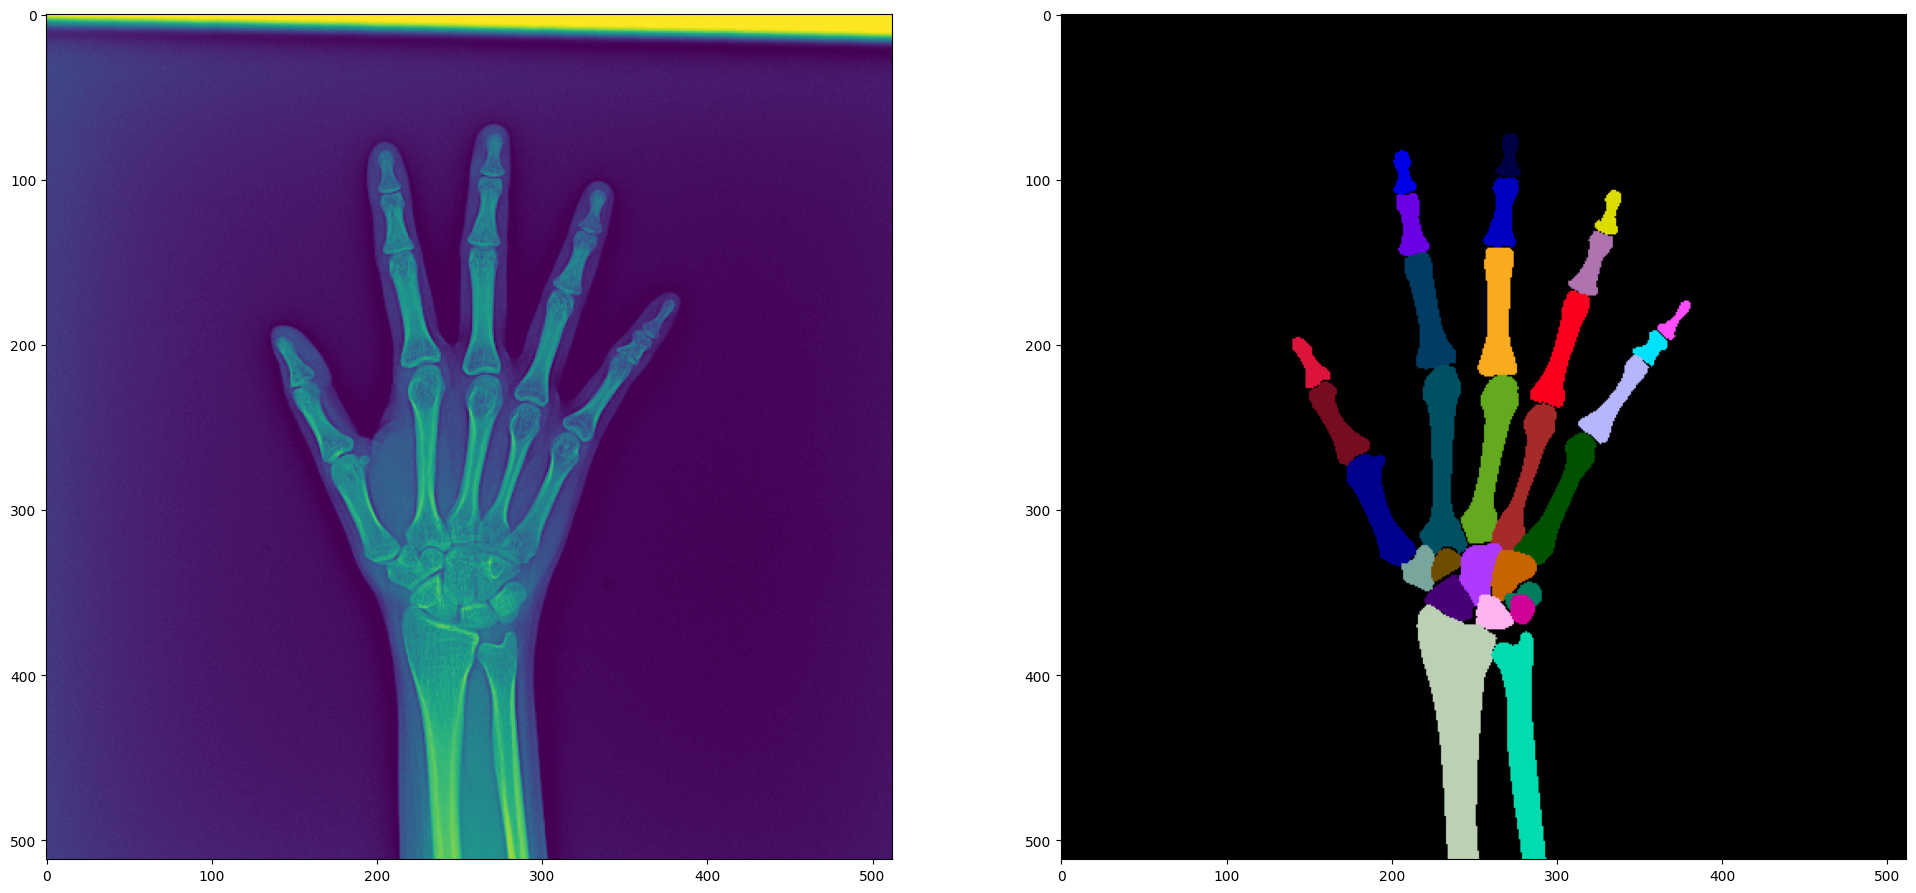

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image[0])    # color map 적용을 위해 channel 차원을 생략합니다.
ax[1].imshow(label2rgb(label))

plt.show()

# Setup Dataloader

In [22]:
train_loader = DataLoader(
    dataset=train_dataset,
    # batch_size=BATCH_SIZE,
    batch_size=1,
    shuffle=True,
    num_workers=8,
    drop_last=True,
)

# 주의: validation data는 이미지 크기가 크기 때문에 `num_wokers`는 커지면 메모리 에러가 발생할 수 있습니다.
valid_loader = DataLoader(
    dataset=valid_dataset,
    # batch_size=BATCH_SIZE,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

# Define Functions for Training

In [23]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten(2)
    y_pred_f = y_pred.flatten(2)
    intersection = torch.sum(y_true_f * y_pred_f, -1)

    eps = 0.0001
    return (2. * intersection + eps) / (torch.sum(y_true_f, -1) + torch.sum(y_pred_f, -1) + eps)

In [24]:
def save_model(model, file_name='efficient_unet_best_model_nz_28.pt'):
    output_path = os.path.join(SAVED_DIR, file_name)
    torch.save(model, output_path)

In [25]:
def set_seed():
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

In [26]:
def soft_dice(y_true, y_prob, eps=1e-6):
    # y_true, y_prob: (B,C,H,W) float
    inter = (y_true * y_prob).sum(dim=(2,3))
    union = y_true.sum(dim=(2,3)) + y_prob.sum(dim=(2,3))
    dice  = (2*inter + eps) / (union + eps)
    return dice.mean().item() if dice.numel() > 0 else 0.0

def validation(epoch, model, loader, criterion, thrs=(0.3,0.4,0.5)):
    model.eval()
    loss_sum, n = 0.0, 0
    dice_thr_sum = {t:0.0 for t in thrs}
    dice_soft_sum = 0.0

    with torch.no_grad():
        for images, masks in loader:
            images = images.cuda(non_blocking=True)
            masks  = masks.cuda(non_blocking=True).float()  # BCE류/ Dice류 모두 float 필요

            logits = model(images)  # SMP는 tensor logits 반환
            loss = criterion(logits, masks)
            loss_sum += loss.item(); n += 1

            prob = torch.sigmoid(logits)
            dice_soft_sum += soft_dice(masks, prob)

            for t in thrs:
                pred = (prob > t).float()
                dice_thr_sum[t] += soft_dice(masks, pred)

    print(f"Epoch[{epoch}] val_loss={loss_sum/n:.4f}, soft_dice={dice_soft_sum/n:.4f}, " +
          ", ".join([f"dice@{t}={dice_thr_sum[t]/n:.4f}" for t in thrs]))
    return dice_thr_sum[0.5]/n


In [27]:
def validation(epoch, model, loader, criterion, thr=0.5):
    print(f'Start validation #{epoch:2d}')
    model.eval()
    dices = []

    with torch.no_grad():
        total_loss = 0

        # for images, masks in loader:
        for _, (images, masks) in tqdm(enumerate(loader), total=len(loader)):
            # images = images.cuda(non_blocking=True)
            # masks  = masks.cuda(non_blocking=True).float()  # BCE류/ Dice류 모두 float 필요
            images, masks = images.cuda(), masks.cuda()

            logits = model(images)  # SMP는 tensor logits 반환

            output_h, output_w = logits.size(-2), logits.size(-1)
            mask_h, mask_w = masks.size(-2), masks.size(-1)

            # gt와 prediction의 크기가 다른 경우 prediction을 gt에 맞춰 interpolation 합니다.
            if output_h != mask_h or output_w != mask_w:
                outputs = F.interpolate(outputs, size=(mask_h, mask_w), mode="bilinear")

            loss = criterion(logits, masks)
            # total_loss += loss.item()
            total_loss += loss

            outputs = torch.sigmoid(logits)
            outputs = (outputs > thr).detach().cpu()
            masks = masks.detach().cpu()

            dice = dice_coef(outputs, masks)
            dices.append(dice)


    dices = torch.cat(dices, 0)
    dices_per_class = torch.mean(dices, 0)
    dice_str = [
        f"{c:<12}: {d.item():.4f}"
        for c, d in zip(CLASSES, dices_per_class)
    ]
    dice_str = "\n".join(dice_str)
    print(dice_str)

    avg_dice = torch.mean(dices_per_class).item()

    return avg_dice

In [28]:
def train(model, data_loader, val_loader, criterion, optimizer):
    print(f'Start training..')
    
    best_dice = 0.
    model = model.cuda()
    
    for epoch in range(NUM_EPOCHS):
        model.train()

        for step, (images, masks) in enumerate(data_loader):            
            images = images.cuda()
            
            masks = masks.cuda().float() #수정
            
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (step + 1) % 25 == 0:
                print(
                    f'{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} | '
                    f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
                    f'Step [{step+1}/{len(train_loader)}], '
                    f'Loss: {round(loss.item(),4)}'
                )
             
        if (epoch + 1) % VAL_EVERY == 0:
            dice = validation(epoch + 1, model, val_loader, criterion)
            
            if best_dice < dice:
                print(f"Best performance at epoch: {epoch + 1}, {best_dice:.4f} -> {dice:.4f}")
                print(f"Save model in {SAVED_DIR}")
                best_dice = dice
                save_model(model) 

# Training

## `smp.Unet()`

In [29]:
#jupyter command 에서 library download 하기
# !pip install git+https://github.com/qubvel/segmentation_models.pytorch

import segmentation_models_pytorch as smp

# model 불러오기
# 출력 label 수 정의 (classes=29)
# model = smp.Unet(
#     encoder_name="efficientnet-b4", # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=29,                     # model output channels (number of classes in your dataset)
# )
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b4", # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=29,                     # model output channels (number of classes in your dataset)
)

In [30]:
from segmentation_models_pytorch.losses import DiceLoss, SoftBCEWithLogitsLoss
# Loss function을 정의합니다.
# criterion = DiceLoss(mode="multilabel")
# criterion = nn.BCEWithLogitsLoss() + DiceLoss(mode="multilabel")
# criterion = BCEDiceLoss(bce_weight=0.5, dice_weight=0.5)

# from segmentation_models_pytorch.losses import DiceLoss

# bce_loss = nn.BCEWithLogitsLoss()
# bce_loss  = SoftBCEWithLogitsLoss()
# dice_loss = DiceLoss(mode="binary", from_logits=True)

# def criterion(outputs, targets):
#     return 0.5*bce_loss(outputs, targets) + 0.5*dice_loss(outputs, targets)
#     # return 0.3*bce_loss(outputs, targets) + 0.7*dice_loss(outputs, targets)

dice = smp.losses.DiceLoss(mode="binary", from_logits=True)
bce  = smp.losses.SoftBCEWithLogitsLoss()

class ComboLoss(nn.Module):
    def __init__(self, w_dice=0.7, w_bce=0.3):
        super().__init__()
        self.dice = dice
        self.bce = bce
        self.w_dice = w_dice
        self.w_bce = w_bce
    def forward(self, y_pred, y_true):
        return self.w_dice * self.dice(y_pred, y_true) + self.w_bce * self.bce(y_pred, y_true)

criterion = ComboLoss()

# Optimizer를 정의합니다.
optimizer = optim.Adam(params=model.parameters(), lr=LR, weight_decay=1e-6)

In [31]:
# 시드를 설정합니다.
set_seed()

In [32]:
train(model, train_loader, valid_loader, criterion, optimizer)

Start training..
2025-12-18 12:41:07 | Epoch [1/28], Step [25/640], Loss: 0.7587
2025-12-18 12:41:13 | Epoch [1/28], Step [50/640], Loss: 0.6928
2025-12-18 12:41:18 | Epoch [1/28], Step [75/640], Loss: 0.6125
2025-12-18 12:41:25 | Epoch [1/28], Step [100/640], Loss: 0.4574
2025-12-18 12:41:31 | Epoch [1/28], Step [125/640], Loss: 0.3995
2025-12-18 12:41:37 | Epoch [1/28], Step [150/640], Loss: 0.4012
2025-12-18 12:41:43 | Epoch [1/28], Step [175/640], Loss: 0.3462
2025-12-18 12:41:49 | Epoch [1/28], Step [200/640], Loss: 0.3577
2025-12-18 12:41:56 | Epoch [1/28], Step [225/640], Loss: 0.3082
2025-12-18 12:42:02 | Epoch [1/28], Step [250/640], Loss: 0.293
2025-12-18 12:42:08 | Epoch [1/28], Step [275/640], Loss: 0.2997
2025-12-18 12:42:14 | Epoch [1/28], Step [300/640], Loss: 0.3011
2025-12-18 12:42:19 | Epoch [1/28], Step [325/640], Loss: 0.2954
2025-12-18 12:42:26 | Epoch [1/28], Step [350/640], Loss: 0.281
2025-12-18 12:42:32 | Epoch [1/28], Step [375/640], Loss: 0.301
2025-12-18 12:

  0%|          | 0/160 [00:00<?, ?it/s]

finger-1    : 0.0000
finger-2    : 0.0000
finger-3    : 0.9658
finger-4    : 0.0000
finger-5    : 0.0000
finger-6    : 0.0000
finger-7    : 0.9786
finger-8    : 0.0000
finger-9    : 0.0000
finger-10   : 0.0000
finger-11   : 0.9672
finger-12   : 0.0000
finger-13   : 0.0000
finger-14   : 0.9533
finger-15   : 0.0000
finger-16   : 0.0000
finger-17   : 0.0000
finger-18   : 0.0000
finger-19   : 0.9671
Trapezium   : 0.0000
Trapezoid   : 0.0000
Capitate    : 0.9553
Hamate      : 0.0000
Scaphoid    : 0.1561
Lunate      : 0.0000
Triquetrum  : 0.0000
Pisiform    : 0.0000
Radius      : 0.9860
Ulna        : 0.9799
Best performance at epoch: 4, 0.0000 -> 0.2727
Save model in checkpoints
2025-12-18 12:53:10 | Epoch [5/28], Step [25/640], Loss: 0.2072
2025-12-18 12:53:17 | Epoch [5/28], Step [50/640], Loss: 0.2185
2025-12-18 12:53:23 | Epoch [5/28], Step [75/640], Loss: 0.2208
2025-12-18 12:53:29 | Epoch [5/28], Step [100/640], Loss: 0.227
2025-12-18 12:53:35 | Epoch [5/28], Step [125/640], Loss: 0.22

  0%|          | 0/160 [00:00<?, ?it/s]

finger-1    : 0.6188
finger-2    : 0.9323
finger-3    : 0.9707
finger-4    : 0.7008
finger-5    : 0.8929
finger-6    : 0.9551
finger-7    : 0.9630
finger-8    : 0.8298
finger-9    : 0.8649
finger-10   : 0.9369
finger-11   : 0.9596
finger-12   : 0.7522
finger-13   : 0.7185
finger-14   : 0.8189
finger-15   : 0.9590
finger-16   : 0.0000
finger-17   : 0.7839
finger-18   : 0.9569
finger-19   : 0.9691
Trapezium   : 0.9153
Trapezoid   : 0.8991
Capitate    : 0.9539
Hamate      : 0.9257
Scaphoid    : 0.9576
Lunate      : 0.9413
Triquetrum  : 0.9156
Pisiform    : 0.8238
Radius      : 0.9161
Ulna        : 0.9010
Best performance at epoch: 8, 0.2727 -> 0.8528
Save model in checkpoints
2025-12-18 13:05:11 | Epoch [9/28], Step [25/640], Loss: 0.0199
2025-12-18 13:05:18 | Epoch [9/28], Step [50/640], Loss: 0.0225
2025-12-18 13:05:24 | Epoch [9/28], Step [75/640], Loss: 0.0204
2025-12-18 13:05:30 | Epoch [9/28], Step [100/640], Loss: 0.0221
2025-12-18 13:05:37 | Epoch [9/28], Step [125/640], Loss: 0.0

  0%|          | 0/160 [00:00<?, ?it/s]

finger-1    : 0.9268
finger-2    : 0.9283
finger-3    : 0.9416
finger-4    : 0.9359
finger-5    : 0.9438
finger-6    : 0.9701
finger-7    : 0.9658
finger-8    : 0.9297
finger-9    : 0.8943
finger-10   : 0.9718
finger-11   : 0.9747
finger-12   : 0.8979
finger-13   : 0.7451
finger-14   : 0.9112
finger-15   : 0.9628
finger-16   : 0.8142
finger-17   : 0.8404
finger-18   : 0.9682
finger-19   : 0.9566
Trapezium   : 0.9375
Trapezoid   : 0.9115
Capitate    : 0.9617
Hamate      : 0.9406
Scaphoid    : 0.9649
Lunate      : 0.9552
Triquetrum  : 0.9420
Pisiform    : 0.8925
Radius      : 0.9902
Ulna        : 0.9886
Best performance at epoch: 12, 0.8528 -> 0.9298
Save model in checkpoints
2025-12-18 13:16:54 | Epoch [13/28], Step [25/640], Loss: 0.0169
2025-12-18 13:17:00 | Epoch [13/28], Step [50/640], Loss: 0.0153
2025-12-18 13:17:06 | Epoch [13/28], Step [75/640], Loss: 0.0163
2025-12-18 13:17:11 | Epoch [13/28], Step [100/640], Loss: 0.0159
2025-12-18 13:17:18 | Epoch [13/28], Step [125/640], Los

  0%|          | 0/160 [00:00<?, ?it/s]

finger-1    : 0.9313
finger-2    : 0.9443
finger-3    : 0.9723
finger-4    : 0.7851
finger-5    : 0.5922
finger-6    : 0.8437
finger-7    : 0.9674
finger-8    : 0.8403
finger-9    : 0.8058
finger-10   : 0.8972
finger-11   : 0.9633
finger-12   : 0.8406
finger-13   : 0.8105
finger-14   : 0.9085
finger-15   : 0.9684
finger-16   : 0.9103
finger-17   : 0.8957
finger-18   : 0.9624
finger-19   : 0.9668
Trapezium   : 0.9290
Trapezoid   : 0.8959
Capitate    : 0.9385
Hamate      : 0.9160
Scaphoid    : 0.9381
Lunate      : 0.9381
Triquetrum  : 0.9346
Pisiform    : 0.8686
Radius      : 0.9845
Ulna        : 0.9786
2025-12-18 13:28:33 | Epoch [17/28], Step [25/640], Loss: 0.017
2025-12-18 13:28:39 | Epoch [17/28], Step [50/640], Loss: 0.0133
2025-12-18 13:28:45 | Epoch [17/28], Step [75/640], Loss: 0.0163
2025-12-18 13:28:51 | Epoch [17/28], Step [100/640], Loss: 0.0139
2025-12-18 13:28:57 | Epoch [17/28], Step [125/640], Loss: 0.0118
2025-12-18 13:29:03 | Epoch [17/28], Step [150/640], Loss: 0.016


  0%|          | 0/160 [00:00<?, ?it/s]

finger-1    : 0.9343
finger-2    : 0.9506
finger-3    : 0.9657
finger-4    : 0.8469
finger-5    : 0.8465
finger-6    : 0.9522
finger-7    : 0.9718
finger-8    : 0.9364
finger-9    : 0.9407
finger-10   : 0.9628
finger-11   : 0.9768
finger-12   : 0.8870
finger-13   : 0.8740
finger-14   : 0.9372
finger-15   : 0.9707
finger-16   : 0.8604
finger-17   : 0.8990
finger-18   : 0.9678
finger-19   : 0.9720
Trapezium   : 0.9437
Trapezoid   : 0.9087
Capitate    : 0.9642
Hamate      : 0.9507
Scaphoid    : 0.9664
Lunate      : 0.9584
Triquetrum  : 0.9468
Pisiform    : 0.8949
Radius      : 0.9904
Ulna        : 0.9889
Best performance at epoch: 20, 0.9298 -> 0.9368
Save model in checkpoints
2025-12-18 13:40:16 | Epoch [21/28], Step [25/640], Loss: 0.0145
2025-12-18 13:40:22 | Epoch [21/28], Step [50/640], Loss: 0.0248
2025-12-18 13:40:28 | Epoch [21/28], Step [75/640], Loss: 0.0184
2025-12-18 13:40:34 | Epoch [21/28], Step [100/640], Loss: 0.015
2025-12-18 13:40:40 | Epoch [21/28], Step [125/640], Loss

  0%|          | 0/160 [00:00<?, ?it/s]

finger-1    : 0.9573
finger-2    : 0.9544
finger-3    : 0.9610
finger-4    : 0.9241
finger-5    : 0.9371
finger-6    : 0.9756
finger-7    : 0.9820
finger-8    : 0.9508
finger-9    : 0.9606
finger-10   : 0.9578
finger-11   : 0.9770
finger-12   : 0.9448
finger-13   : 0.9620
finger-14   : 0.9638
finger-15   : 0.9772
finger-16   : 0.9582
finger-17   : 0.9532
finger-18   : 0.9765
finger-19   : 0.9777
Trapezium   : 0.9419
Trapezoid   : 0.9145
Capitate    : 0.9632
Hamate      : 0.9497
Scaphoid    : 0.9651
Lunate      : 0.9575
Triquetrum  : 0.9492
Pisiform    : 0.8987
Radius      : 0.9885
Ulna        : 0.9858
Best performance at epoch: 24, 0.9368 -> 0.9574
Save model in checkpoints
2025-12-18 13:52:09 | Epoch [25/28], Step [25/640], Loss: 0.0172
2025-12-18 13:52:15 | Epoch [25/28], Step [50/640], Loss: 0.012
2025-12-18 13:52:21 | Epoch [25/28], Step [75/640], Loss: 0.0237
2025-12-18 13:52:27 | Epoch [25/28], Step [100/640], Loss: 0.0146
2025-12-18 13:52:33 | Epoch [25/28], Step [125/640], Loss

  0%|          | 0/160 [00:00<?, ?it/s]

finger-1    : 0.9501
finger-2    : 0.9494
finger-3    : 0.9487
finger-4    : 0.8409
finger-5    : 0.9069
finger-6    : 0.9651
finger-7    : 0.9798
finger-8    : 0.8506
finger-9    : 0.8992
finger-10   : 0.9675
finger-11   : 0.9765
finger-12   : 0.8550
finger-13   : 0.8650
finger-14   : 0.9599
finger-15   : 0.9717
finger-16   : 0.9438
finger-17   : 0.9319
finger-18   : 0.9742
finger-19   : 0.9704
Trapezium   : 0.9242
Trapezoid   : 0.9080
Capitate    : 0.9601
Hamate      : 0.9426
Scaphoid    : 0.9633
Lunate      : 0.9556
Triquetrum  : 0.9255
Pisiform    : 0.8757
Radius      : 0.9893
Ulna        : 0.9866


# Inference

In [33]:
model = torch.load(os.path.join(SAVED_DIR, "efficient_unet_best_model_nz_28.pt"))

In [ ]:
# 테스트 데이터 경로를 입력하세요

IMAGE_ROOT = "../data/test/DCM"

In [35]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [36]:
len(pngs)

288

In [37]:
# mask map으로 나오는 인퍼런스 결과를 RLE로 인코딩 합니다.

def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask
    1 - mask
    0 - background
    Returns encoded run length
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [38]:
# RLE로 인코딩된 결과를 mask map으로 복원합니다.

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)

    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape(height, width)

In [39]:
class XRayInferenceDataset(Dataset):
    def __init__(self, transforms=None):
        _filenames = pngs
        _filenames = np.array(sorted(_filenames))

        self.filenames = _filenames
        self.transforms = transforms

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image / 255.

        if self.transforms is not None:
            inputs = {"image": image}
            result = self.transforms(**inputs)
            image = result["image"]

        # to tensor will be done later
        image = image.transpose(2, 0, 1)

        image = torch.from_numpy(image).float()

        return image, image_name

In [40]:
def test(model, data_loader, thr=0.5):
    model = model.cuda()
    model.eval()

    rles = []
    filename_and_class = []
    with torch.no_grad():
        n_class = len(CLASSES)

        for step, (images, image_names) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images = images.cuda()
            outputs = model(images)

            outputs = F.interpolate(outputs, size=(2048, 2048), mode="bilinear")
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu().numpy()

            for output, image_name in zip(outputs, image_names):
                for c, segm in enumerate(output):
                    rle = encode_mask_to_rle(segm)
                    rles.append(rle)
                    filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")

    return rles, filename_and_class

In [41]:
tf = A.Resize(512, 512)

In [42]:
test_dataset = XRayInferenceDataset(transforms=tf)

In [43]:
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

In [44]:
rles, filename_and_class = test(model, test_loader)

  0%|          | 0/144 [00:00<?, ?it/s]

# Result Visualization

In [45]:
filename_and_class[0]

'finger-1_ID040/image1661319116107.png'

In [46]:
image = cv2.imread(os.path.join(IMAGE_ROOT, filename_and_class[0].split("_")[1]))

In [47]:
preds = []
for rle in rles[:len(CLASSES)]:
    pred = decode_rle_to_mask(rle, height=2048, width=2048)
    preds.append(pred)

preds = np.stack(preds, 0)

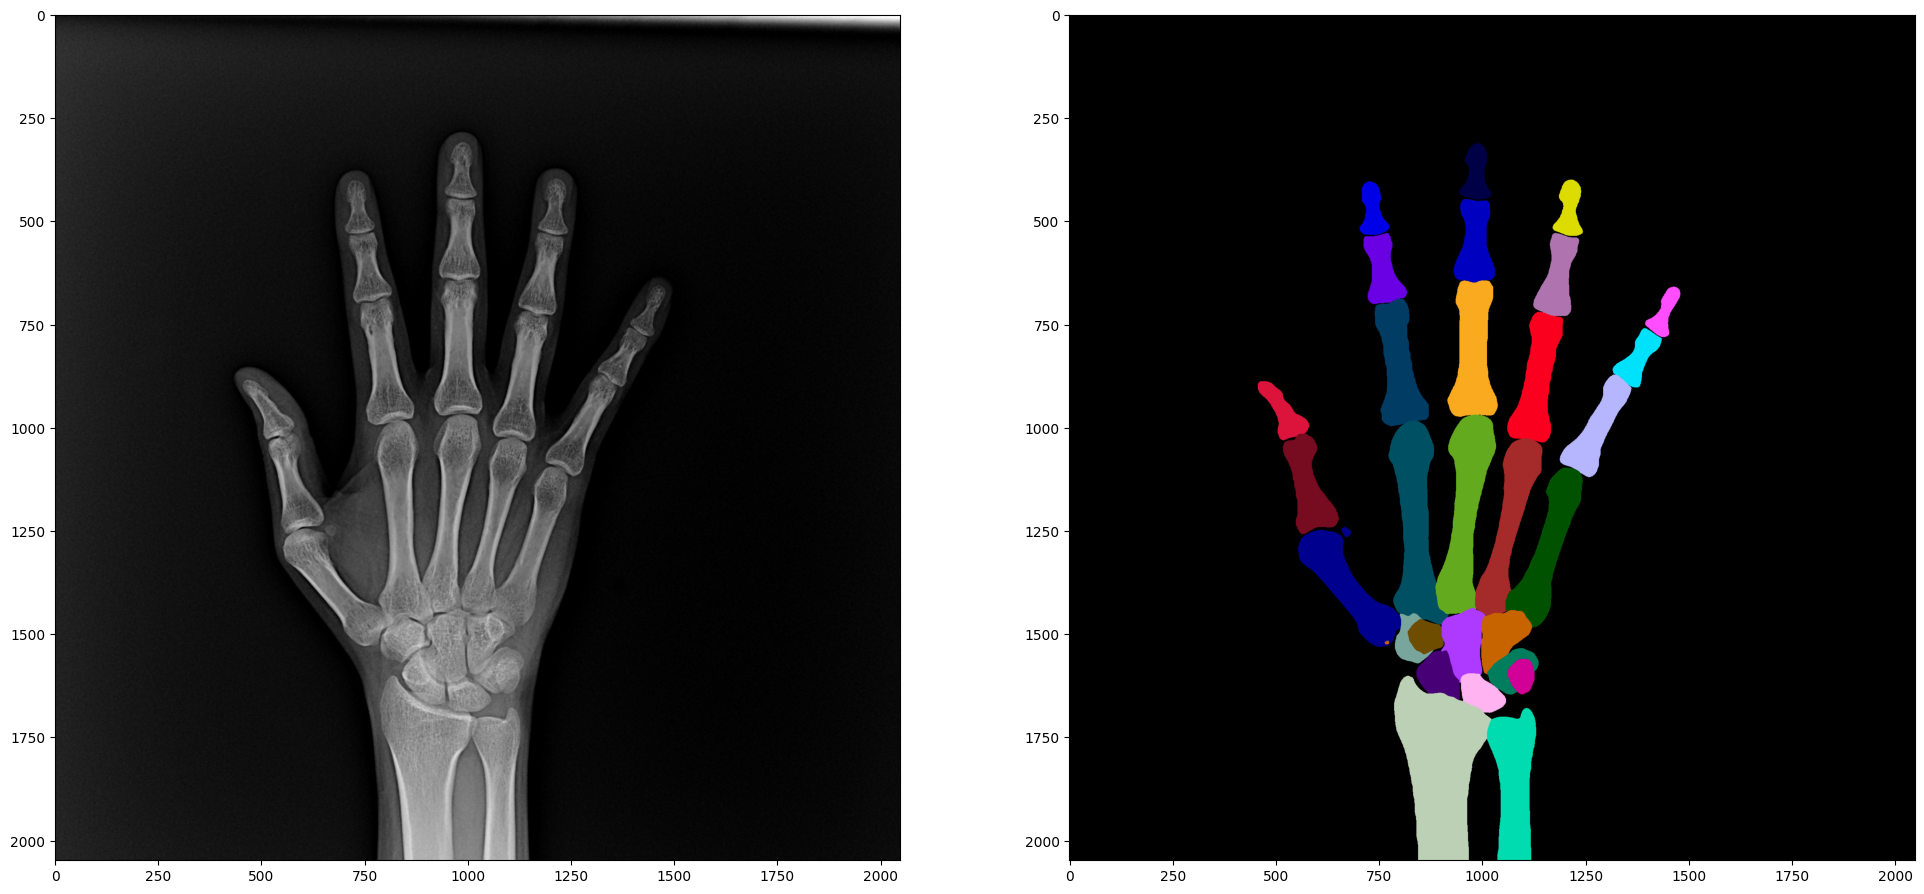

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image)    # remove channel dimension
ax[1].imshow(label2rgb(preds))

plt.show()

# To CSV

In [49]:
classes, filename = zip(*[x.split("_") for x in filename_and_class])

In [50]:
image_name = [os.path.basename(f) for f in filename]

In [51]:
df = pd.DataFrame({
    "image_name": image_name,
    "class": classes,
    "rle": rles,
})

In [52]:
df.head(30)

,image_name,class,rle
0,image1661319116107.png,finger-1,1821135 18 1823182 23 1825229 26 1827276 29 18...
1,image1661319116107.png,finger-2,2081328 15 2083372 21 2085419 24 2087466 26 20...
2,image1661319116107.png,finger-3,2544283 5 2546329 8 2548375 11 2550421 14 2552...
3,image1661319116107.png,finger-4,830166 4 832210 13 834257 17 836303 21 838350 ...
4,image1661319116107.png,finger-5,1086208 5 1088253 10 1090298 13 1092343 17 109...
5,image1661319116107.png,finger-6,1411869 12 1413914 17 1415960 20 1418006 23 14...
6,image1661319116107.png,finger-7,2016062 11 2018105 20 2020150 26 2022196 30 20...
7,image1661319116107.png,finger-8,642008 12 644054 15 646101 18 648147 22 650194...
8,image1661319116107.png,finger-9,918461 13 920506 22 922554 26 924601 30 924656...
9,image1661319116107.png,finger-10,1321916 5 1321958 16 1323960 15 1324002 24 132...


In [53]:
df.to_csv("efficient_unet_best_model_28epoch.csv", index=False)

### **콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.

### **데이터셋 저작권**

<font color='red'><b>**WARNING**</b></font> : 캠프 교육용 라이선스 (대외 노출 금지)